In [1]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold



import random
import datetime as dt
import time


from sklearn import preprocessing
import tensorflow as tf

import import_ipynb
import sys

import network_arch as network
import metrics
import plot
import settings 


In [2]:
# --- Inline Settings ---
HIDDENS = [128, 32]  # Hidden layer sizes
NLABEL = 2  # Binary classification (positive/negative NAO)
RIDGE1 = 0.0  # L2 regularization
DROPOUT = 0.0  # Dropout rate
LR_INIT = 0.001  # Initial learning rate
NETWORK_SEED = 42  # Random seed
BATCH_SIZE = 32  # Batch size
EPOCHS = 100  # Number of epochs

In [3]:
# --- Custom Metric: PredictionAccuracy ---
class PredictionAccuracy(tf.keras.metrics.Metric):
    def __init__(self, nlabel, name='prediction_accuracy', **kwargs):
        super(PredictionAccuracy, self).__init__(name=name, **kwargs)
        self.nlabel = nlabel
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=1)
        y_pred = tf.argmax(y_pred, axis=1)
        correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
        total = tf.cast(tf.size(y_true), tf.float32)
        self.correct.assign_add(correct)
        self.total.assign_add(total)

    def result(self):
        return self.correct / self.total

    def reset_states(self):
        self.correct.assign(0.0)
        self.total.assign(0.0)

In [4]:
# --- Neural Network Architecture ---
def defineNN(hiddens, input1_shape, output_shape, ridge_penalty1, dropout, act_fun, network_seed):
    tf.random.set_seed(network_seed)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input1_shape,)))
    for units in hiddens:
        model.add(tf.keras.layers.Dense(
            units,
            activation=act_fun,
            kernel_regularizer=tf.keras.regularizers.l2(ridge_penalty1)
        ))
        if dropout > 0:
            model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(output_shape, activation='softmax'))
    return model

def make_model(input_shape):
    tf.keras.backend.clear_session()
    model = defineNN(
        HIDDENS,
        input1_shape=input_shape,
        output_shape=NLABEL,
        ridge_penalty1=RIDGE1,
        dropout=DROPOUT,
        act_fun='relu',
        network_seed=NETWORK_SEED
    )
    loss_function = tf.keras.losses.CategoricalCrossentropy()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR_INIT),
        loss=loss_function,
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy"),
            PredictionAccuracy(NLABEL)
        ]
    )
    return model, loss_function

import math

def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    return float(lr * math.exp(-0.1))

In [5]:
# --- Preprocessing ---
# Detrend function
def detrend_data(data, dim='valid_time'):
    if dim not in data.dims or data.sizes[dim] == 0:
        raise ValueError(f"Dimension {dim} not found or empty")
    time_vals = (data[dim] - data[dim][0]) / np.timedelta64(1, 'D')
    def detrend_ufunc(t, y):
        if np.all(np.isnan(y)) or len(np.unique(y[~np.isnan(y)])) < 2:
            return y
        slope, intercept, _, _, _ = linregress(t, y)
        return y - (slope * t + intercept)
    detrended = xr.apply_ufunc(
        detrend_ufunc, time_vals, data,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[dim]],
        vectorize=True
    )
    return detrended

In [6]:
nc_msl = r"C:/Users/31610/Documents/UvA/Master thesis/Data/slp.nc"
# Opening the NETCDF files using xarray
ds_msl = xr.open_dataset(nc_msl)
ds = ds_msl.isel(latitude=slice(None, None, 4), longitude=slice(None, None, 4))
# Define the NAO region in the 0° to 360° range
lat_min, lat_max = 20, 80  # 20°N to 80°N
lon_min_360, lon_max_360 = 270, 40  # 90°W (270°E) to 40°E

# Select the two parts of the longitude range
lon_part1 = ds.sel(
    latitude=slice(lat_max, lat_min),  # 80°N to 20°N
    longitude=slice(lon_min_360, 360)  # 270°E to 360°
)

lon_part2 = ds.sel(
    latitude=slice(lat_max, lat_min),  # 80°N to 20°N
    longitude=slice(0, lon_max_360)  # 0° to 40°E
)
nao_data = xr.concat([lon_part1, lon_part2], dim='longitude')
print(nao_data)




<xarray.Dataset> Size: 210MB
Dimensions:     (valid_time: 6567, latitude: 61, longitude: 131)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 53kB 1940-01-01 ... 2024-12-31
  * latitude    (latitude) float64 488B 80.0 79.0 78.0 77.0 ... 22.0 21.0 20.0
  * longitude   (longitude) float64 1kB 270.0 271.0 272.0 ... 38.0 39.0 40.0
    expver      (valid_time) <U4 105kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    msl         (valid_time, latitude, longitude) float32 210MB 1.042e+05 ......
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-17T16:02 GRIB to CDM+CF via cfgrib-0.9.1...


<xarray.Dataset> Size: 210MB
Dimensions:     (valid_time: 6567, latitude: 61, longitude: 131)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 53kB 1940-01-01 ... 2024-12-31
  * latitude    (latitude) float64 488B 80.0 79.0 78.0 77.0 ... 22.0 21.0 20.0
  * longitude   (longitude) float64 1kB 270.0 271.0 272.0 ... 38.0 39.0 40.0
    expver      (valid_time) <U4 105kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    msl         (valid_time, latitude, longitude) float32 210MB 1.042e+05 ......
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-17T16:02 GRIB to CDM+CF via cfgrib-0.9.1...


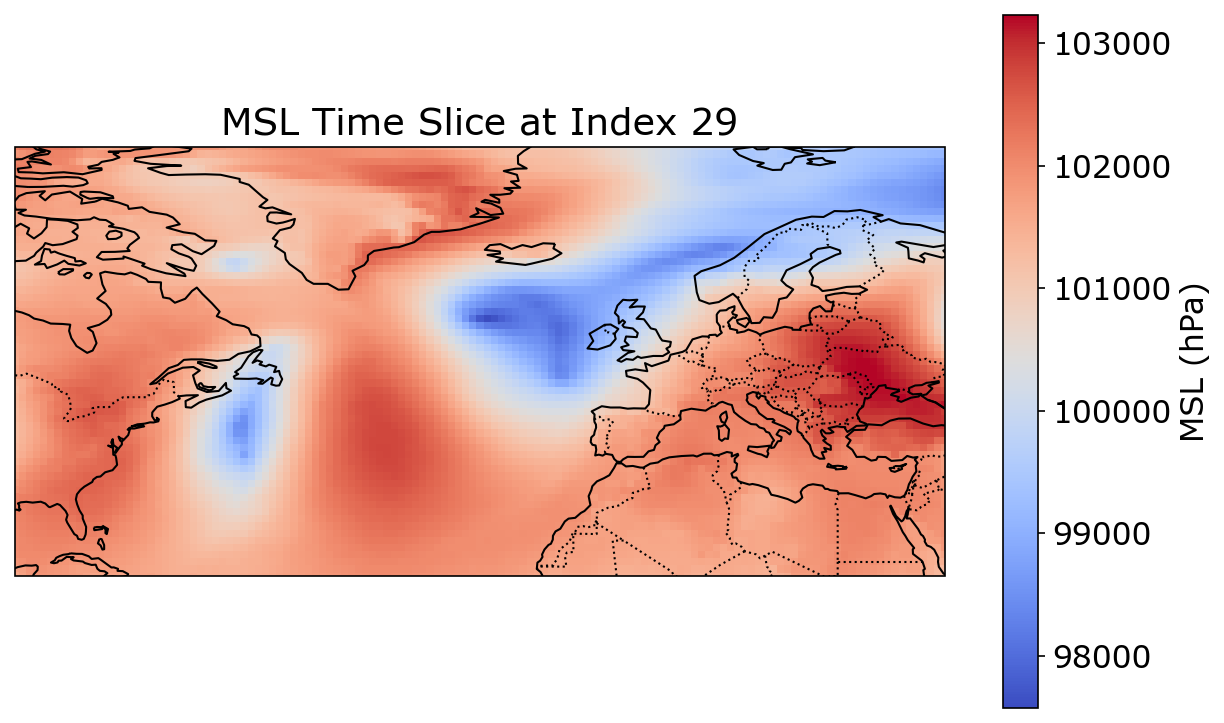

In [8]:
# Visualizing a time slice of the data with land boundaries and limited range
def plot_time_slice_with_boundaries_limited(data, time_index):
    # Disable LaTeX rendering in Matplotlib to avoid the error
    plt.rcParams['text.usetex'] = False
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Ensure longitudes are sorted
    data = data.sortby('longitude')

    # Get the range of latitude and longitude
    lat_min = data['latitude'].values.min()
    lat_max = data['latitude'].values.max()
    lon_min = data['longitude'].values.min()
    lon_max = data['longitude'].values.max()

    # Set the extent of the plot to match the data range
    ax.set_extent([-90, 40, 20, 80], crs=ccrs.PlateCarree())

    # Plot the data
    data['msl'].isel(valid_time=time_index).plot(
        ax=ax, x='longitude', y='latitude', cmap='coolwarm', cbar_kwargs={'label': 'MSL (hPa)'},
        transform=ccrs.PlateCarree()
    )
    plt.title(f'MSL Time Slice at Index {time_index}')
    plt.xlabel('Longitude (°E)')
    plt.ylabel('Latitude (°N)')
    plt.show()

# Plotting the first time slice with limited range
print(nao_data)
plot_time_slice_with_boundaries_limited(nao_data, 29)

In [9]:
# Compute anomalies
climatology = nao_data['msl'].mean(dim='valid_time')
X_all = nao_data['msl'] - climatology

# Detrend
X_all_detrended = detrend_data(X_all)

# Flatten and standardize
X_all_flat = X_all_detrended.stack(z=('latitude', 'longitude')).transpose('valid_time', 'z')
X_all_mean = X_all_flat.mean(dim='valid_time')
X_all_std_dev = X_all_flat.std(dim='valid_time')
X_all_std_dev = xr.where(X_all_std_dev == 0, 1, X_all_std_dev)  # Avoid division by zero
X_all_normalized = (X_all_flat - X_all_mean) / X_all_std_dev
print("X_all_normalized shape:", X_all_normalized.shape)


X_all_normalized shape: (6567, 7991)


X_all_normalized shape: (6567, 7991)
X_all_unstacked shape: (6567, 61, 131)
input_data_normalized shape: (61, 131)
input_data shape: (61, 131)


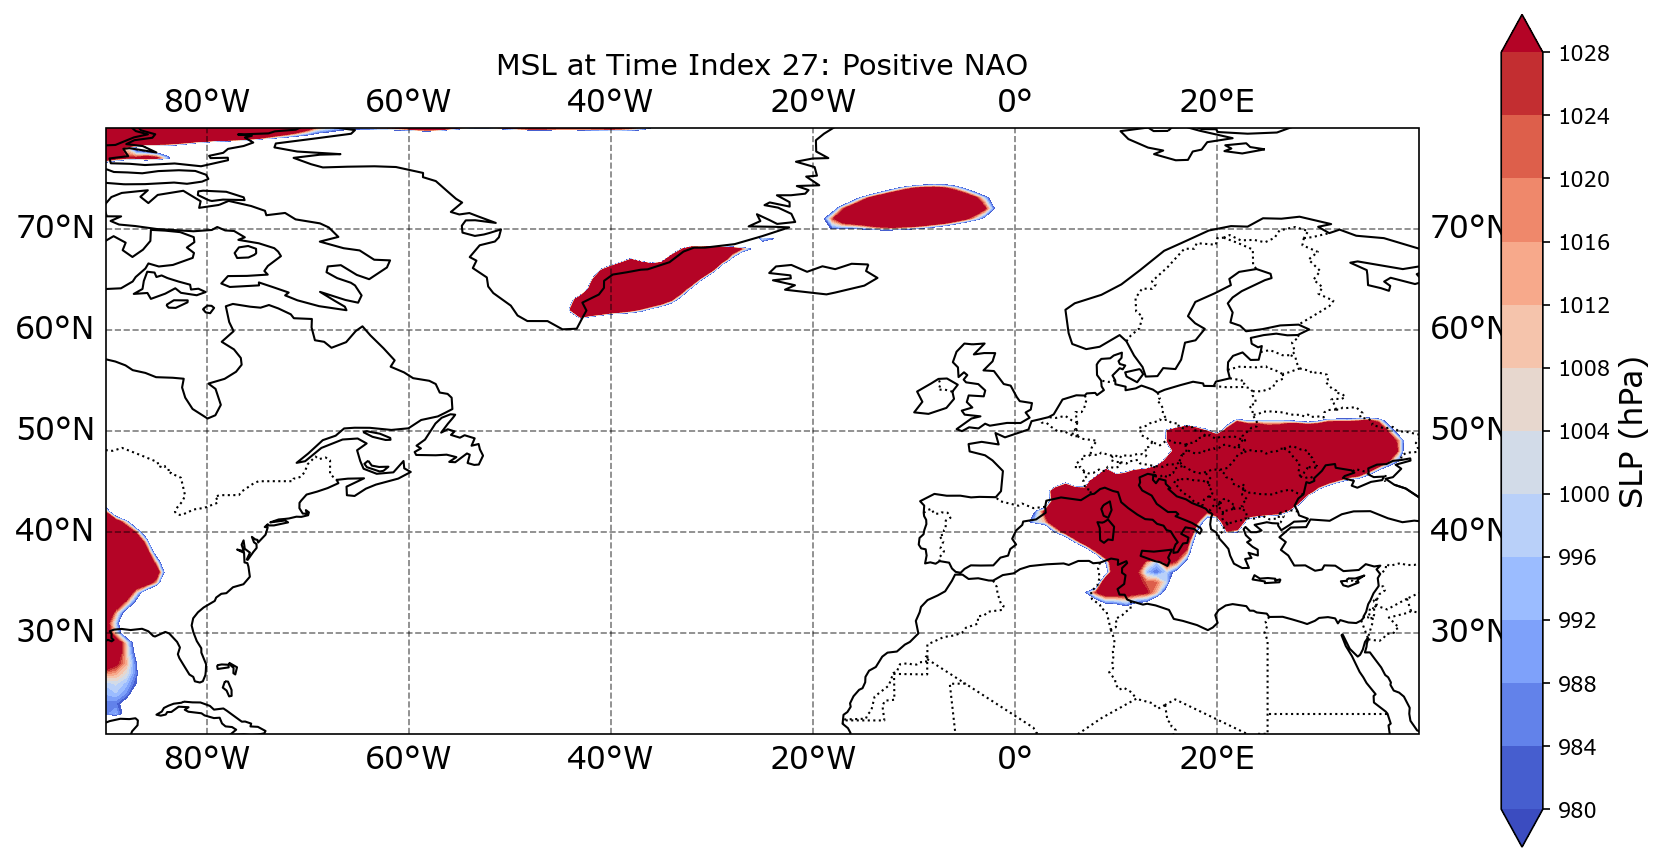

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

# Your original plotting function with visual enhancements
def plot_input_field_with_prediction(input_data, lats, lons, prediction, title_prefix="Model Prediction"):
    """
    Visualize a single input field (e.g., SLP) with a predicted label.

    Parameters:
    - input_data: 2D array of shape (lat x lon), the field to plot (e.g., SLP)
    - lats, lons: 1D or 2D arrays of latitude and longitude values
    - prediction: int, predicted class label (e.g., 0 or 1)
    - title_prefix: str, custom prefix for the title
    """
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-90, 40, 20, 80], crs=ccrs.PlateCarree())

    # Default Cartopy styling
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Add gridlines
    ax.gridlines(draw_labels=True, linestyle='--', color='black', alpha=0.5)

    if lats.ndim == 1 and lons.ndim == 1:
        lons, lats = np.meshgrid(lons, lats)

    # Define levels for discrete color steps
    levels = np.arange(980, 1032, 4)  # Adjust based on your data range

    # Filled contours with blue-to-red colormap
    contour = ax.contourf(
        lons, lats, input_data,
        levels=levels,
        cmap='coolwarm',
        transform=ccrs.PlateCarree(),
        extend='both'
    )

    # Enhanced colorbar
    cbar = plt.colorbar(contour, ax=ax, orientation='vertical', label='SLP (hPa)', ticks=levels)
    cbar.ax.tick_params(labelsize=10)

    ax.set_title(f"{title_prefix}: {'Positive NAO' if prediction == 1 else 'Negative NAO'}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Your data preprocessing steps
# Compute anomalies
climatology = nao_data['msl'].mean(dim='valid_time')
X_all = nao_data['msl'] - climatology

# Detrend
X_all_detrended = detrend_data(X_all)

# Flatten and standardize
X_all_flat = X_all_detrended.stack(z=('latitude', 'longitude')).transpose('valid_time', 'z')
X_all_mean = X_all_flat.mean(dim='valid_time')
X_all_std_dev = X_all_flat.std(dim='valid_time')
X_all_std_dev = xr.where(X_all_std_dev == 0, 1, X_all_std_dev)  # Avoid division by zero
X_all_normalized = (X_all_flat - X_all_mean) / X_all_std_dev
print("X_all_normalized shape:", X_all_normalized.shape)

# Step 1: Unstack the flattened data
# Unstack the 'z' dimension back into 'latitude' and 'longitude'
X_all_unstacked = X_all_normalized.unstack('z')
print("X_all_unstacked shape:", X_all_unstacked.shape)  # Should be (valid_time, latitude, longitude)

# Step 2: Select a time slice and rescale to hPa
sample_idx = 27 # Same as your previous plot
input_data_normalized = X_all_unstacked.isel(valid_time=sample_idx)  # Select 2D slice
print("input_data_normalized shape:", input_data_normalized.shape)

# Rescale back to hPa (since X_all_normalized is in standardized units)
# Note: X_all_mean and X_all_std_dev are 1D arrays along 'z', so we need to unstack them too
X_all_mean_unstacked = X_all_mean.unstack('z')
X_all_std_dev_unstacked = X_all_std_dev.unstack('z')

input_data = (input_data_normalized * X_all_std_dev_unstacked) + X_all_mean_unstacked
print("input_data shape:", input_data.shape)

# Step 3: Extract lats, lons, and prediction
lats = nao_data['latitude'].values
lons = nao_data['longitude'].values
prediction = y_pred_classes[sample_idx]  # From your model predictions

# Step 4: Plot the map
plot_input_field_with_prediction(input_data.values, lats, lons, prediction, title_prefix=f"MSL at Time Index {sample_idx}")

In [ ]:
# Define NAO regions (Iceland: 65–70°N, 340–350°E; Azores: 35–40°N, 325–335°E)
iceland = nao_data.sel(latitude=slice(70, 65), longitude=slice(340, 350)).mean(dim=['latitude', 'longitude'])
azores = nao_data.sel(latitude=slice(40, 35), longitude=slice(325, 335)).mean(dim=['latitude', 'longitude'])

nao_index = iceland['msl'] - azores['msl']
print(nao_index[0:10])

print("iceland shape:", iceland)
print("azores shape:", azores)
print("nao_index values:", nao_index.values)
print("nao_index min/max:", nao_index.min().values, nao_index.max().values)

# Apply 21 (22)-day (11 time steps) lead time by shifting the time coordinate
lead = 11  # 21 days / 48 hours = 10.5, rounded to 11 time steps
days_average = 7  # 14 days / 48 hours = 7 time steps

# Shift the time coordinate of nao_index
shifted_time = nao_index['valid_time'].values + np.timedelta64(lead * 2, 'D')
nao_index_shifted = nao_index.assign_coords(valid_time=shifted_time)



# Apply 14-day (7 time steps) rolling average
Y_all = nao_index_shifted.rolling(valid_time=days_average, center=True).mean()
print(Y_all[0:10])

# Handle NaNs due to rolling (keep only non-NaN entries)
valid_indices = np.where(~np.isnan(Y_all))[0]
print("Valid indices:", valid_indices)

# Ensure valid indices are within the bounds of X_all_normalized
valid_indices = valid_indices[valid_indices < len(X_all_normalized)]

# Apply valid indices to Y_all and X_all_normalized
Y_all = Y_all.isel(valid_time=valid_indices)
X_all_normalized = X_all_normalized.isel(valid_time=valid_indices)

# Binarize and one-hot encode
Ytrain_med = np.median(Y_all)
Y_all_binary = xr.where(Y_all >= Ytrain_med, 1, 0)

print("Ytrain_med:", Ytrain_med)
Y_all_binary = xr.where(Y_all >= Ytrain_med, 1, 0)

#print("Y_all_binary values:", Y_all_binary.values)
# Convert to DataFrame for one-hot encoding
#Y_all_binary_df = pd.DataFrame(Y_all_binary.values, columns=['NAO'])

# One-hot encode
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse_output=False)
Y_all_onehot = enc.fit_transform(Y_all_binary.values.reshape(-1, 1))
print("Y_all_onehot shape:", Y_all_onehot.shape)

<xarray.DataArray 'msl' (valid_time: 10)> Size: 40B
array([ 1444.5547 ,   639.25   ,  -332.1172 , -1307.8828 ,   -69.78125,
       -2464.1094 , -1081.8203 ,  2127.0547 ,  2725.7266 ,   767.10156],
      dtype=float32)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 80B 1940-01-01 ... 1940-01-19
    expver      (valid_time) <U4 160B '0001' '0001' '0001' ... '0001' '0001'
iceland shape: <xarray.Dataset> Size: 184kB
Dimensions:     (valid_time: 6567)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 53kB 1940-01-01 ... 2024-12-31
    expver      (valid_time) <U4 105kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    msl         (valid_time) float32 26kB 1.014e+05 1.018e+05 ... 1.021e+05
azores shape: <xarray.Dataset> Size: 184kB
Dimensions:     (valid_time: 6567)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 53kB 1940-01-01 ... 2024-12-31
    expver      (valid_time) <U4 1

In [30]:
# --- Class Balancing ---
pos_indices = np.where(Y_all_binary == 1)[0]
neg_indices = np.where(Y_all_binary == 0)[0]
n_samples = min(len(pos_indices), len(neg_indices))
pos_subset = np.random.choice(pos_indices, n_samples, replace=False)
neg_subset = np.random.choice(neg_indices, n_samples, replace=False)
# Ensure balanced_indices are valid for X_all_normalized and Y_all_onehot
balanced_indices = np.concatenate([pos_subset, neg_subset])
# Ensure balanced_indices are within the valid range of X_all_normalized and Y_all_onehot
balanced_indices = balanced_indices[balanced_indices < len(X_all_normalized)]

# Apply the balanced indices
X_all_normalized = X_all_normalized.isel(valid_time=balanced_indices)
Y_all_onehot = Y_all_onehot[balanced_indices]
print("X_all_normalized balanced shape:", X_all_normalized.shape)
print("Y_all_onehot balanced shape:", Y_all_onehot.shape)

# Add this after balancing to verify class balance
balanced_labels = np.argmax(Y_all_onehot, axis=1)
classes, counts = np.unique(balanced_labels, return_counts=True)

for c, n in zip(classes, counts):
    print(f"Class {c}: {n} samples")


X_all_normalized balanced shape: (6546, 7991)
Y_all_onehot balanced shape: (6546, 2)
Class 0: 3273 samples
Class 1: 3273 samples


In [55]:

# --- Split the data into training and validation sets ---
val_split = int(0.2 * len(X_all_normalized))  # 20% for validation
X_train = X_all_normalized[:-val_split]  # All but the last 20% for training
Y_train = Y_all_onehot[:-val_split]  # Same for labels
X_val = X_all_normalized[-val_split:]  # The last 20% for validation
Y_val = Y_all_onehot[-val_split:]  # The same for validation labels

# Decode Y_train from one-hot to labels
y_train_labels = np.argmax(Y_train, axis=1)
print("Y_train class distribution:", np.bincount(y_train_labels))

# Similarly for Y_val (assuming Y_val shape is (1312, 2))
y_val_labels = np.argmax(Y_val, axis=1)
print("Y_val class distribution:", np.bincount(y_val_labels))
print("Y_val unique labels:", np.unique(y_val_labels))
# --- Compute class weights for the training labels ---
from sklearn.utils.class_weight import compute_class_weight

# Convert one-hot encoded labels to class labels
Y_train_classes = np.argmax(Y_train, axis=1)

# Compute class weights for the training labels
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train_classes), y=Y_train_classes)

# Create a dictionary of class weights
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

# --- Training the model with class weights ---
model, loss_function = make_model(input_shape=X_all_normalized.shape[1])
history = model.fit(
    X_train, Y_train,  # Your training data
    epochs=EPOCHS,  # Number of epochs
    batch_size=BATCH_SIZE,  # Batch size
    validation_data=(X_val, Y_val),  # Validation data
    class_weight=class_weight_dict,  # Class weights to handle imbalance
    verbose=1,  # Show progress during training
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(scheduler)
    ]
)




Y_train class distribution: [2472 2758]
Y_val class distribution: [796 511]
Y_val unique labels: [0 1]
Class Weights: {0: np.float64(1.0578478964401294), 1: np.float64(0.948150833937636)}
Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - categorical_accuracy: 0.4920 - loss: 2.3682 - prediction_accuracy: 0.4920 - val_categorical_accuracy: 0.4797 - val_loss: 1.3810 - val_prediction_accuracy: 0.4797 - learning_rate: 0.0010
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - categorical_accuracy: 0.5247 - loss: 1.1437 - prediction_accuracy: 0.5247 - val_categorical_accuracy: 0.4858 - val_loss: 1.0356 - val_prediction_accuracy: 0.4858 - learning_rate: 0.0010
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - categorical_accuracy: 0.5331 - loss: 0.8152 - prediction_accuracy: 0.5331 - val_categorical_accuracy: 0.4155 - val_loss: 0.9122 - val_prediction_accuracy: 0.4155 - learning_rate: 0.0010
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - categorical_accuracy: 0.5709 -

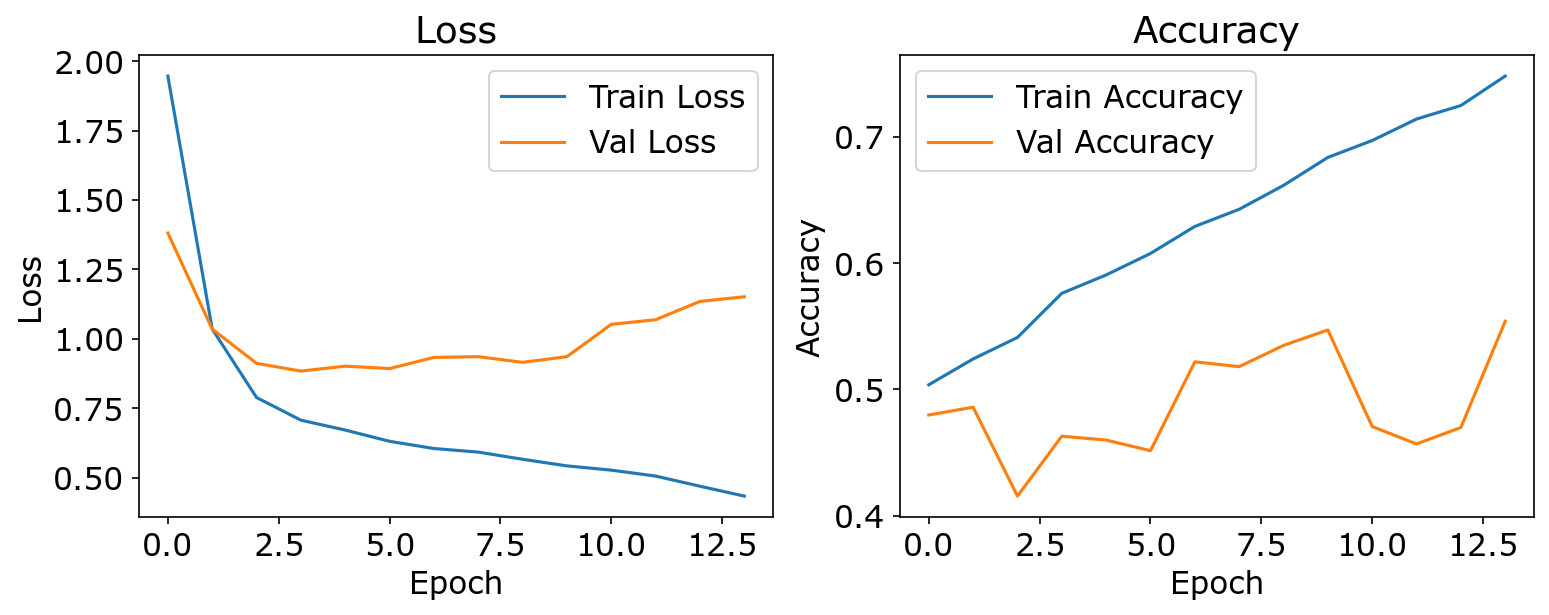

In [56]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_history.png')
plt.show()

In [57]:
# Evaluate on validation set
val_split = int(0.2 * len(X_all_normalized))
X_val = X_all_normalized[-val_split:]
Y_val = Y_all_onehot[-val_split:]
val_loss, val_accuracy, val_pred_accuracy = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Prediction Accuracy: {val_pred_accuracy:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.4601 - loss: 0.8980 - prediction_accuracy: 0.4601
Validation Loss: 0.8844, Accuracy: 0.4629, Prediction Accuracy: 0.4629


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


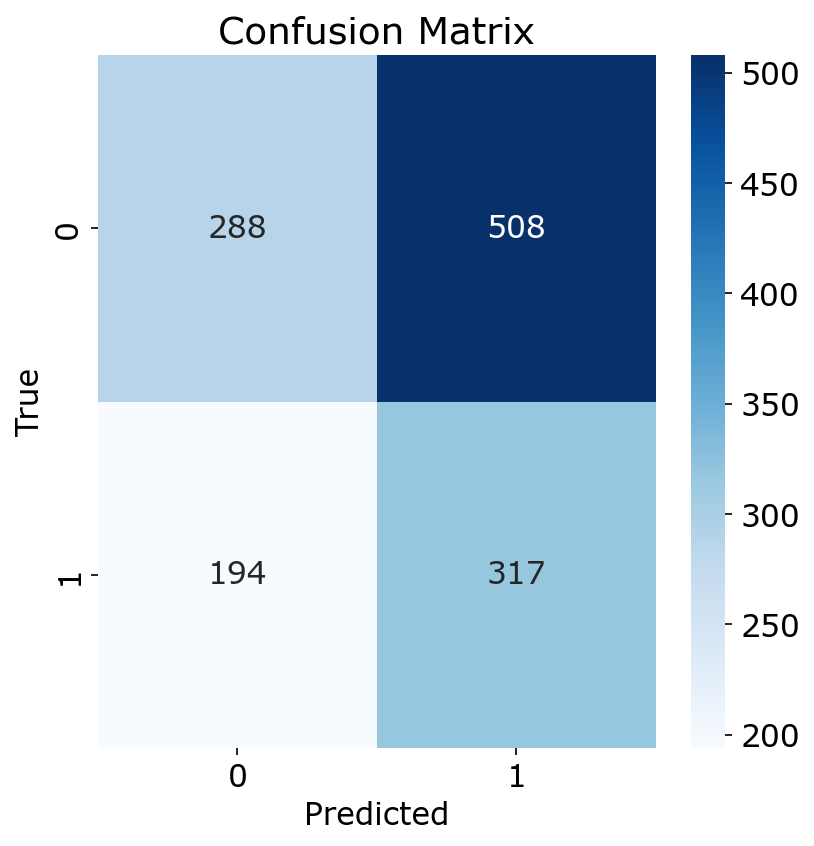

In [58]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_val_classes = np.argmax(Y_val, axis=1)
cm = confusion_matrix(Y_val_classes, Y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [61]:
Y_pred_full_probs = model.predict(X_all_normalized)
print("Y_pred_full_probs shape:", Y_pred_full_probs[10])

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Y_pred_full_probs shape: [0.5063442 0.4936559]


In [64]:
# Check the probability distribution for the first few samples
print("Predicted probabilities for first few samples:", Y_pred_full_probs[:10])

Predicted probabilities for first few samples: [[0.2891699  0.71083015]
 [0.20789583 0.7921042 ]
 [0.49326524 0.5067347 ]
 [0.43765253 0.56234753]
 [0.04012146 0.95987856]
 [0.5034475  0.4965526 ]
 [0.42870986 0.5712902 ]
 [0.4177594  0.58224064]
 [0.49096972 0.50903034]
 [0.07466231 0.9253377 ]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


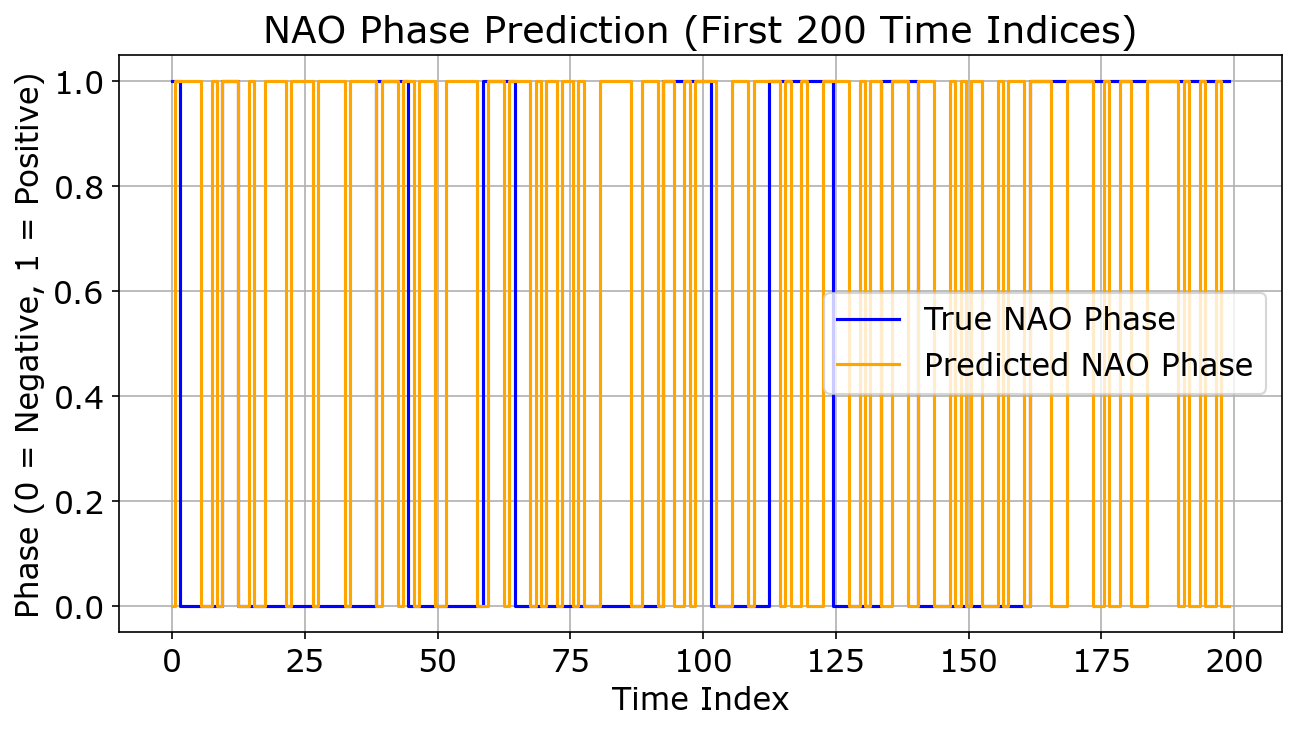

In [63]:
# Step 1: Predict NAO phases for the entire validation set
y_pred = model.predict(X_val)  # Get probabilities for all samples
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices (0 or 1)

# Step 2: Convert true labels to class indices
y_true_classes = np.argmax(Y_val, axis=1)  # Assuming y_val is one-hot encoded

subset_size = 200
plt.figure(figsize=(10, 5))
plt.step(range(subset_size), y_true_classes[:subset_size], label="True NAO Phase", color="blue", where="mid")
plt.step(range(subset_size), y_pred_classes[:subset_size], label="Predicted NAO Phase", color="orange", where="mid")
plt.title("NAO Phase Prediction (First 200 Time Indices)")
plt.xlabel("Time Index")
plt.ylabel("Phase (0 = Negative, 1 = Positive)")
plt.legend()
plt.grid(True)
plt.show()

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_input_field_with_prediction(input_data, lats, lons, prediction, title_prefix="Model Prediction"):
    """
    Visualize a single input field (e.g., SLP) with a predicted label.

    Parameters:
    - input_data: 2D array of shape (lat x lon), the field to plot (e.g., SLP)
    - lats, lons: 1D or 2D arrays of latitude and longitude values
    - prediction: int, predicted class label (e.g., 0 or 1)
    - title_prefix: str, custom prefix for the title
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import numpy as np

    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # Set the extent of the plot to match the data range
    ax.set_extent([-90, 40, 20, 80], crs=ccrs.PlateCarree())

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    if lats.ndim == 1 and lons.ndim == 1:
        lons, lats = np.meshgrid(lons, lats)

    contour = ax.contourf(
    lons, lats, input_data,
    cmap='coolwarm',  # Adjust based on expected range
    transform=ccrs.PlateCarree()
)

    plt.colorbar(contour, ax=ax, orientation='vertical', label='SLP (hPa)')

    ax.set_title(f"{title_prefix}: {'Positive NAO' if prediction == 1 else 'Negative NAO'}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [104]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_input_field_with_prediction(input_data, lats, lons, prediction, title_prefix="Model Prediction"):
    """
    Visualize a single input field (e.g., SLP) with a predicted label.

    Parameters:
    - input_data: 2D array of shape (lat x lon), the field to plot (e.g., SLP)
    - lats, lons: 1D or 2D arrays of latitude and longitude values
    - prediction: int, predicted class label (e.g., 0 or 1)
    - title_prefix: str, custom prefix for the title
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import numpy as np

    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # Set the extent of the plot to match the data range
    ax.set_extent([-90, 40, 20, 80], crs=ccrs.PlateCarree())

    # Default Cartopy styling for land and ocean (remove custom colors)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Add gridlines for better readability
    ax.gridlines(draw_labels=True, linestyle='--', color='black', alpha=0.5)

    if lats.ndim == 1 and lons.ndim == 1:
        lons, lats = np.meshgrid(lons, lats)

    # Define levels for discrete color steps (every 4 hPa from 980 to 1030)
    levels = np.arange(980, 1032, 4)  # 980, 984, ..., 1028

    # Filled contours with a colormap that includes both blue and red
    contour = ax.contourf(
        lons, lats, input_data,
        levels=levels,
        cmap='coolwarm',  # Keep coolwarm for blue (low) and red (high)
        transform=ccrs.PlateCarree(),
        extend='both'  # Allow values outside the range
    )

    # Enhanced colorbar with specific ticks
    cbar = plt.colorbar(contour, ax=ax, orientation='vertical', label='SLP (hPa)', ticks=levels)
    cbar.ax.tick_params(labelsize=10)

    ax.set_title(f"{title_prefix}: {'Positive NAO' if prediction == 1 else 'Negative NAO'}", fontsize=14)
    plt.tight_layout()
    plt.show()

 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


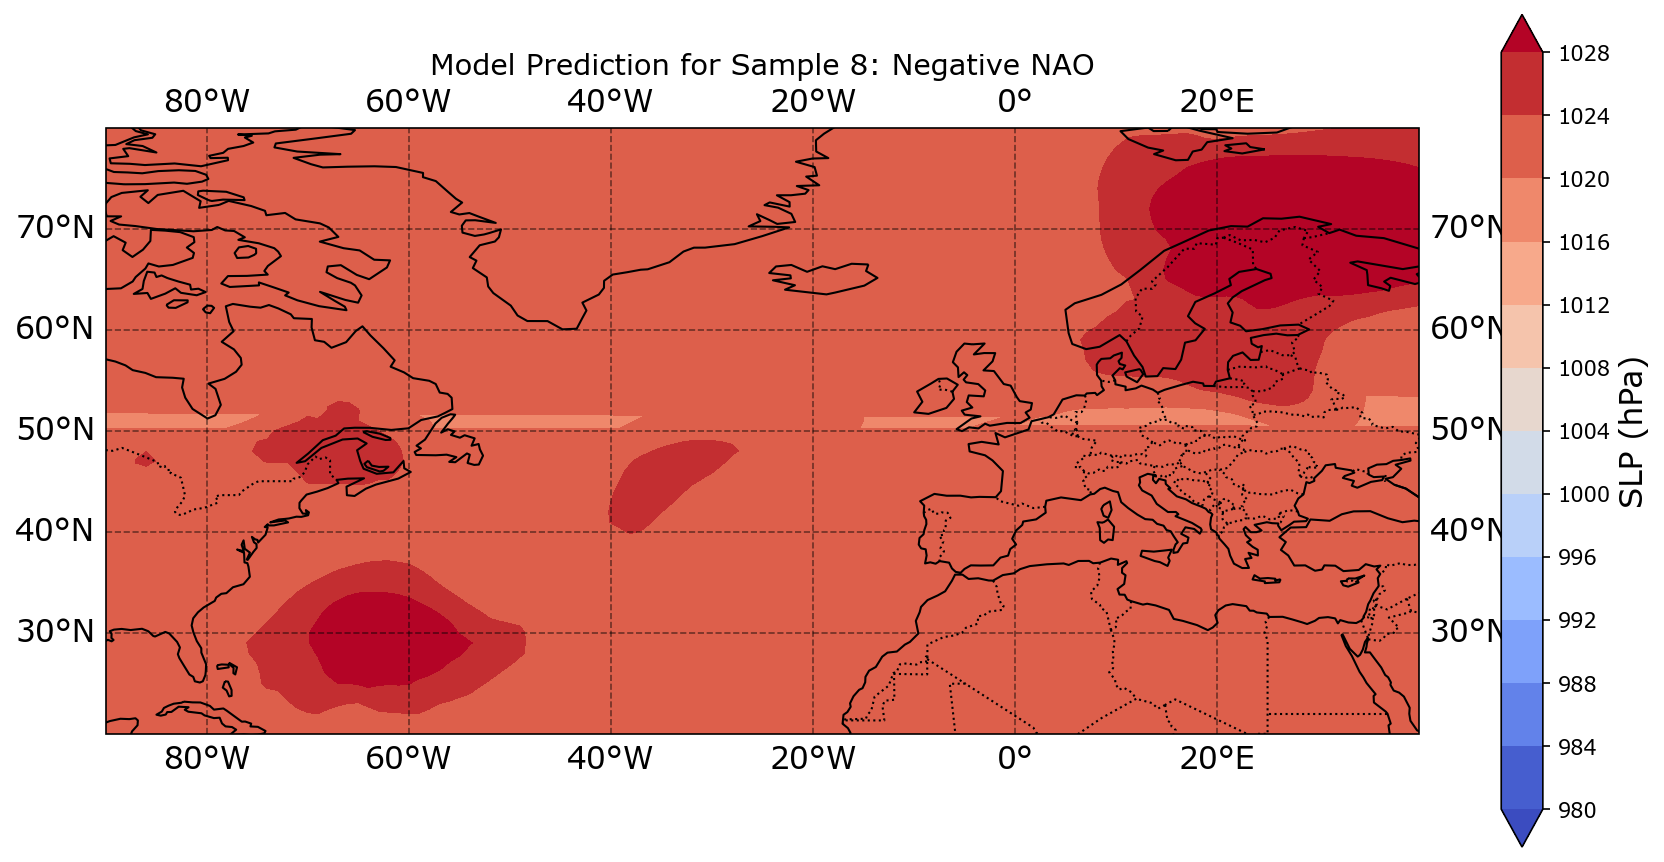

In [106]:
# Step 1: Select a time step
sample_idx = 8
  # You can change this index to any sample

# Step 2: Extract flattened input
sample_input = X_val[sample_idx]

# Step 3: De-normalize using the stored climatology mean and std dev
sample_input_unnorm = (sample_input * X_all_std_dev) + X_all_mean

# Step 4: Reshape to 2D grid (lat x lon)
sample_input_2d = sample_input_unnorm.values.reshape(len(nao_data.latitude), len(nao_data.longitude))

# Step 5: Predict NAO class
sample_pred = np.argmax(model.predict(X_val[sample_idx:sample_idx+1]), axis=1)[0]

# Step 6: Plot using your function
plot_input_field_with_prediction(
    sample_input_2d,
    nao_data.latitude.values,
    nao_data.longitude.values,
    sample_pred,
    title_prefix=f"Model Prediction for Sample {sample_idx}"
)


